<img src="tweeter.png">

Nowadays social medias such as `Twitter`, `Facbook`, `Instagram`... has gotten a very important role in different aspects of our lives. Since most of the people in the developed countries has easily access to the proper internet, so they can use these social media in their daily life. For example in Taiwan, around 98% of the people including adults are using Facebook in their daily life. 
If you have had these kind of social medias, you know that refreshing it every 30 minutes is very common so one can understand that how these tools are mixed with all our life's detail. This is the reson that universities around the globe have created a new branch of sociology which is called, `computational social science`.
Among these social medias, Twitter has a very important role. Why? It has a directed and dynamic structure. Therefore most of the `political and sociologhical campaigns` start in Twitter and then go to others like Facebook, Instagram ...
For example `#Brexit` has a very important role on one the most dramatic and chalenging political phenomenon of our time. The other instance can be `2016 US Presidentail Election` that got `Trump` elected but still democrats belive that there was internet meddeling on that election by forigners.

In [2]:
# Version of different used libraries
%load_ext watermark
%watermark -p numpy,pandas,matplotlib,seaborn,json,tweepy,nltk,networkx,wordcloud,time,textblob

numpy 1.16.2
pandas 0.25.3
matplotlib 2.2.2
seaborn 0.9.0
json 2.0.9
tweepy 3.7.0
nltk 3.3
networkx 2.2
wordcloud 1.6.0
time unknown
textblob 0.15.3


In [3]:
# Importing libraries
import tweepy
from tweepy.streaming import StreamListener
import time
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
# import twitter_credentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from textblob import TextBlob
import re
from wordcloud import WordCloud
import networkx as nx
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\alisa\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Twitter allows us to mine the data of any user using Twitter API or Tweepy. The data will be tweets extracted from the user. The first thing to do is get the consumer key, consumer secret, access key and access secret from twitter developer available easily for each user. These keys will help the API for authentication.

Steps to obtain keys:
* Login to twitter developer section
* Go to `Create an App`
* Fill the details of the application.
* Click on Create your Twitter Application
* Details of your new app will be shown along with consumer key and consumer secret.
* For access token, click `Create my access token`. The page will refresh and generate access token.

Tweepy is one of the library that should be installed using pip. Now in order to authorize our app to access Twitter on our behalf, we need to use the OAuth Interface. Tweepy provides the convenient Cursor interface to iterate through different types of objects. Twitter allows a maximum of `3200` tweets for extraction.

In [4]:
#### TWITTER AUTHENTICATOR ####
class TwitterAuthenticator():
    """
    A class for authentication of the consumer.
    """
    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)
        return auth

In [5]:
#### TWITTER CLIENT ####
class TwitterClient():
    """
    Access to client's tweets and other user's tweets.
    """
    def __init__(self,twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        # Client
        self.twitter_client = API(self.auth)
        # Other users
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self,num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline,id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self,num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends,id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home,id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [6]:
#### TWITTER STREAM LISTNER ####
class TwitterListener(StreamListener):
    """
    A class that prints received tweets and put them in a file.
    """
    def __init__(self,fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
    
    def on_data(self,data):
        try:
            print(data)
            with open(self.fetched_tweets_filename,"a") as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on data: %s" % str(e))
        return True
    
    def on_error(self,status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

In [7]:
#### TWITTER STREAMER ####
class TwitterStreamer():
    """
    Class for streaming and processing live tweete.
    """
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    def stream_tweets(self,fetched_tweets_filename,hash_tag_list):
        # This handles Twitter authentication and the connection to the Twitter Streaming API.
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth,listener)
        stream.filter(track=hash_tag_list)

In [8]:
class TweetAnalyzer():
    """
    Analyzing the different aspects of the tweet or a group of tweets
    """
    def clean_tweet(self,tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^09A-Za-z\t])|(\w+:\/\/\S+)"," ",tweet).split())
    
    def analyze_sentiment(self,tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    
    def tweets_to_data_frame(self,tweets):
        
        df = pd.DataFrame(data=[tweet.text for tweet in tweets],columns=["tweet"])
        df["length"] = np.array([len(tweet.text) for tweet in tweets])
        df["in_reply_to_screen_name"] = np.array([tweet.in_reply_to_screen_name for tweet in tweets])
        df["id"] = np.array([tweet.id for tweet in tweets])
        df["source"] = np.array([tweet.source for tweet in tweets])
        df["date"] = np.array([tweet.created_at for tweet in tweets])
        df["retweets"] = np.array([tweet.retweet_count for tweet in tweets])
        df["likes"] = np.array([tweet.favorite_count for tweet in tweets])
        
        df["author"] = [tweet.author for tweet in tweets]
        df["in_reply_to_user_id"] = [tweet.in_reply_to_user_id for tweet in tweets]
        df["is_quote_status"] = [tweet.is_quote_status for tweet in tweets]
        df["geo"] = [tweet.geo for tweet in tweets]
        df["lang"] = [tweet.lang for tweet in tweets]
        df["place"] = [tweet.place for tweet in tweets]
        
        
        df["retweet"] = [tweet.retweets for tweet in tweets]
        df["retweeted"] = [tweet.retweeted for tweet in tweets]
        #df["retweeted_status"] = [tweet.retweeted_status for tweet in tweets]
        #df["retweets"] = [tweet.retweets for tweet in tweets]
        
        df["favorite"] = [tweet.favorite for tweet in tweets]
        df["favorited"] = [tweet.favorited for tweet in tweets]
        
        return df

# Time-Series of Likes and Tweets

In this section we will appoint an exact amount of tweetes of one special user account that we want to analys, keep in mind that it have to be less than 3200. Therefore we create a data frame and put as much as features that are present in `JSON` file such as number of tweets, number of likes, place, the device, sentiment of the text... 
Then we can easily use `pandas` data frame to analye what is going on in there!

For example below, we analyse the last 200 tweets of a special user and find out a time series of likes and retweets that he or she recieved during this period of time.


 The average length of all the tweets in dataset:  105.985

 The likes of the most liked tweet:  84849

 The retweets of the most retweeted tweet:  16022


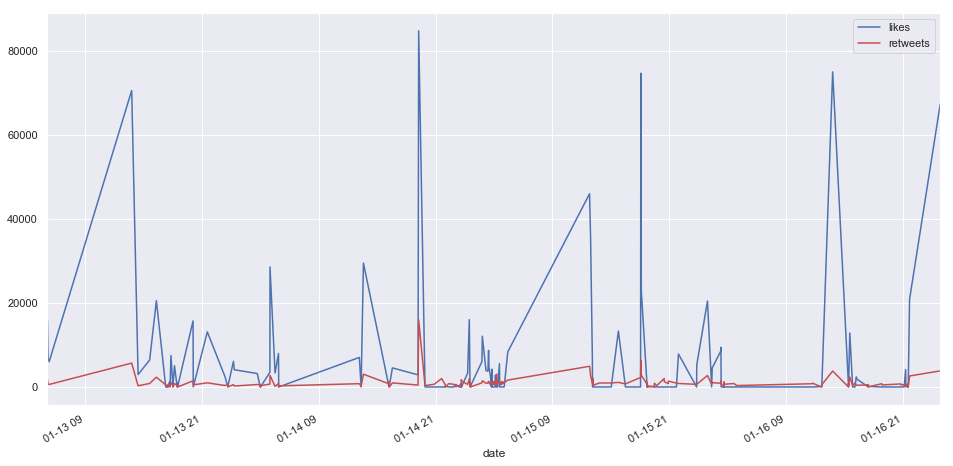

In [9]:
if __name__ == "__main__":
    
#     hash_tag_list = ["YangGang"]
#     fetched_tweets_filename = "tweets.txt"
#     twitter_streamer = TwitterStreamer()
#     twitter_streamer.stream_tweets(fetched_tweets_filename,hash_tag_list)
    
#     # If no argument go through TwitterClient() it will show client's timeline otherwise it will show user's timeline.
#     twitter_client = TwitterClient("AOC")
#     print(twitter_client.get_user_timeline_tweets(1))
#     print(twitter_client.get_friend_list)
#     print(twitter_client.get_home_timeline_tweets)
    
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    api = twitter_client.get_twitter_client_api()
    
    tweets = api.user_timeline(screen_name="andrewyang",count=1000)
    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)
    
    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df["sentiment"] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df["tweet"]])
    #df.head()
    
    # Get average length of all tweets.
    print("\n The average length of all the tweets in dataset: ",np.mean(df["length"]))
    # Get the likes of the most liked tweet.
    print("\n The likes of the most liked tweet: ",np.max(df["likes"]))
    # Get the retweets of the most retweeted tweet.
    print("\n The retweets of the most retweeted tweet: ",np.max(df["retweets"]))
    
    # Visualization on Time Series
    time_likes = pd.Series(data=df["likes"].values,index=df["date"])
    time_likes.plot(figsize=(16,8),label="likes",legend=True,color="b")
    time_retweets = pd.Series(data=df["retweets"].values,index=df["date"])
    time_retweets.plot(figsize=(16,8),label="retweets",legend=True,color="r")
    
    plt.show()

In [10]:
# The data frame of tweets
df.head()

,tweet,length,in_reply_to_screen_name,id,source,date,retweets,likes,author,in_reply_to_user_id,is_quote_status,geo,lang,place,retweet,retweeted,favorite,favorited,sentiment
0,I love my wife very very much.,30,None,1217972359849627648,Twitter for iPhone,2020-01-17 00:50:14,3838,67437,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1
1,Something has changed in the last week or two ...,111,None,1217924789802696704,Twitter for iPhone,2020-01-16 21:41:12,2618,20920,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1
2,@Evan_Low Thanks Evan - thrilled to make histo...,69,Evan_Low,1217922742680309760,Twitter for iPhone,2020-01-16 21:33:04,43,358,User(_api=<tweepy.api.API object at 0x0000019B...,253769656.0,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1
3,RT @colbertlateshow: .@AndrewYang explains how...,140,None,1217922490409684992,Twitter for iPhone,2020-01-16 21:32:04,816,0,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,0
4,RT @jeremyoharris: The endorsement of Andrew Y...,136,None,1217922456649756674,Twitter for iPhone,2020-01-16 21:31:56,625,0,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1


In [11]:
# Create a time_series
df["created_at"] = pd.to_datetime(df["date"],infer_datetime_format="%d/%m/%Y",utc=False)

# Set the index of df to created_at
df = df.set_index("date")
df.head()

,tweet,length,in_reply_to_screen_name,id,source,retweets,likes,author,in_reply_to_user_id,is_quote_status,geo,lang,place,retweet,retweeted,favorite,favorited,sentiment,created_at
date,,,,,,,,,,,,,,,,,,,
2020-01-17 00:50:14,I love my wife very very much.,30,None,1217972359849627648,Twitter for iPhone,3838,67437,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1,2020-01-17 00:50:14
2020-01-16 21:41:12,Something has changed in the last week or two ...,111,None,1217924789802696704,Twitter for iPhone,2618,20920,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1,2020-01-16 21:41:12
2020-01-16 21:33:04,@Evan_Low Thanks Evan - thrilled to make histo...,69,Evan_Low,1217922742680309760,Twitter for iPhone,43,358,User(_api=<tweepy.api.API object at 0x0000019B...,253769656.0,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1,2020-01-16 21:33:04
2020-01-16 21:32:04,RT @colbertlateshow: .@AndrewYang explains how...,140,None,1217922490409684992,Twitter for iPhone,816,0,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,0,2020-01-16 21:32:04
2020-01-16 21:31:56,RT @jeremyoharris: The endorsement of Andrew Y...,136,None,1217922456649756674,Twitter for iPhone,625,0,User(_api=<tweepy.api.API object at 0x0000019B...,NaN,False,None,en,None,<bound method Status.retweets of Status(_api=<...,False,<bound method Status.favorite of Status(_api=<...,False,1,2020-01-16 21:31:56


# Number of Tweets on each Day of Momth

In the below diagrame, using the function `giveday`, we can extract the number of tweets per each day of month!

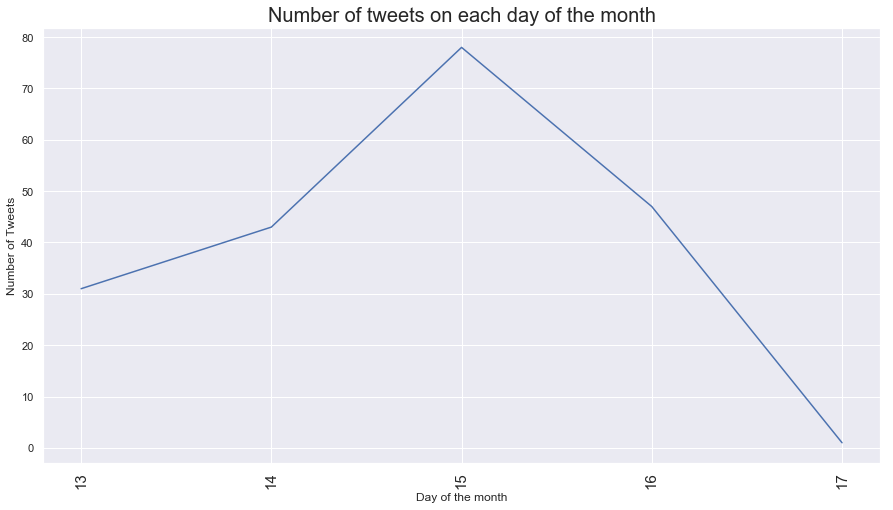

In [15]:
def giveday(timestamp):
    day_string = timestamp.day
    return day_string

df["day"] = df["created_at"].apply(giveday)
days = df.groupby("day")
daycount_t = days["tweet"].count()
timedict_t = daycount_t.to_dict()
# daycount_l = days["likes"].count()
# timedict_l = daycount_l.to_dict()

fig = plt.figure(figsize=(15,8))
plt.plot(list(timedict_t.keys()),list(timedict_t.values()))
# plt.plot(list(timedict_l.keys()),list(timedict_l.values()))
plt.xlabel('Day of the month',fontsize=12)
plt.ylabel('Number of Tweets',fontsize=12)
plt.xticks(list(timedict_t.keys()),fontsize=15,rotation=90)
plt.title('Number of tweets on each day of the month',fontsize=20)
plt.show()

# Total number of Likes and Tweets

Below visualization shows us that what are the total number of likes and retweets that the special user account has got upon their last 200 tweets. Since retweets, mostly, means not endorsment so always the number of likes will be much more than number of retweets.

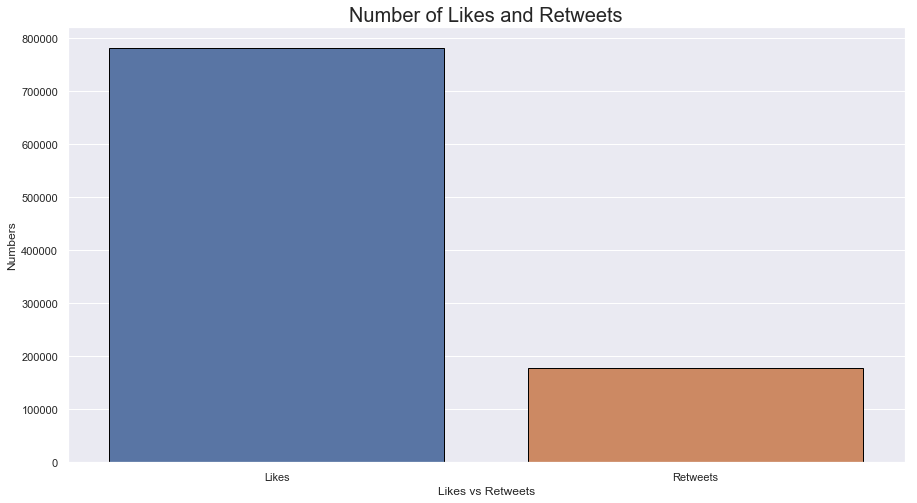

In [92]:
len_list = [df["likes"].sum(),df["retweets"].sum()]
item_list = ['Likes','Retweets']

plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
plt.title('Number of Likes and Retweets',fontsize=20)
plt.xlabel('Likes vs Retweets')
plt.ylabel('Numbers')
sns.barplot(x=item_list,y=len_list,edgecolor='black',linewidth=1)

plt.show()

# Most used #hashtags

In the era of Twitter campaigning, #s have a very crucial role. MOst of the campaigns try to create and use a hashtag that is easy to understand and very related to the topic. Then they try to trend it so the people in charge will be pressured and may be do something about it. One of the most important and influencial hashtags are `#MeToo` in which lots of celebrities have to confese on their moral corruptions.

In [16]:
# To see the most used hashtags.
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(df['tweet'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

In [17]:
# Making a list of the most used hashtags and their values
hashtag_ordered_list =sorted(hashtag_dict.items(),key=lambda x:x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]

# Separating the hashtags and their values into two different lists
hashtag_ordered_values = []
hashtag_ordered_keys = []

# Pick the 20 most used hashtags to plot
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])

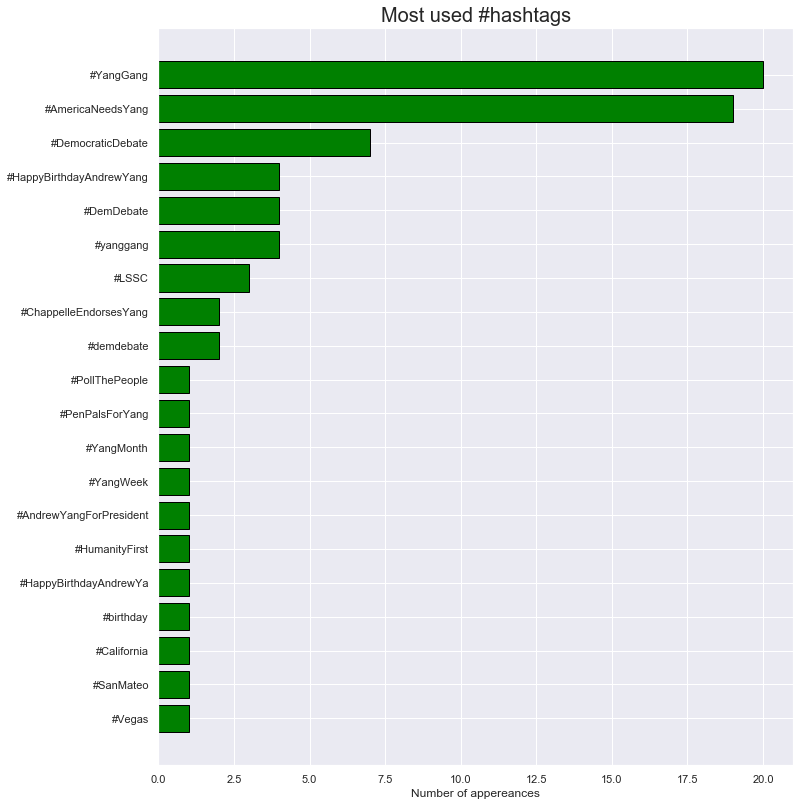

In [18]:
# Plotting a graph with the most used hashtags
fig, ax = plt.subplots(figsize=(12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos,list(hashtag_ordered_values)[::-1],align='center',color ='green',edgecolor='black',linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Number of appereances")
ax.set_title("Most used #hashtags",fontsize=20)
plt.tight_layout(pad=3)
plt.show()

In [96]:
# Top 5 #hashtags
print(hashtag_ordered_keys[:5])

['#YangGang', '#AmericaNeedsYang', '#DemocraticDebate', '#yanggang', '#HappyBirthdayAndrewYang']


In [97]:
# Proportion of the most mentioned #hashtags in the tweets
hash_tag_1 = df["tweet"].str.contains(hashtag_ordered_keys[:5][0],case=False)
hash_tag_2 = df["tweet"].str.contains(hashtag_ordered_keys[:5][1],case=False)
hash_tag_3 = df["tweet"].str.contains(hashtag_ordered_keys[:5][2],case=False)
hash_tag_4 = df["tweet"].str.contains(hashtag_ordered_keys[:5][3],case=False)
hash_tag_5 = df["tweet"].str.contains(hashtag_ordered_keys[:5][4],case=False)

print("Proportion of "+hashtag_ordered_keys[:5][0]+" tweets is:",hash_tag_1.sum()/df.shape[0])
print("Proportion of "+hashtag_ordered_keys[:5][1]+" tweets is:",hash_tag_2.sum()/df.shape[0])
print("Proportion of "+hashtag_ordered_keys[:5][2]+" tweets is:",hash_tag_3.sum()/df.shape[0])
print("Proportion of "+hashtag_ordered_keys[:5][3]+" tweets is:",hash_tag_4.sum()/df.shape[0])
print("Proportion of "+hashtag_ordered_keys[:5][4]+" tweets is:",hash_tag_5.sum()/df.shape[0])

Proportion of #YangGang tweets is: 0.125
Proportion of #AmericaNeedsYang tweets is: 0.095
Proportion of #DemocraticDebate tweets is: 0.035
Proportion of #yanggang tweets is: 0.125
Proportion of #HappyBirthdayAndrewYang tweets is: 0.02


In [98]:
# df[hashtag_ordered_keys[:5][0]] = hash_tag_1
# df[hashtag_ordered_keys[:5][1]] = hash_tag_2
# df[hashtag_ordered_keys[:5][2]] = hash_tag_3
# df[hashtag_ordered_keys[:5][3]] = hash_tag_4
# df[hashtag_ordered_keys[:5][4]] = hash_tag_5

# # Average of keyword columns by day
# mean_1 = df[hashtag_ordered_keys[:5][0]].resample("1 d").mean()
# mean_2 = df[hashtag_ordered_keys[:5][1]].resample("1 d").mean()
# mean_3 = df[hashtag_ordered_keys[:5][2]].resample("1 d").mean()
# mean_4 = df[hashtag_ordered_keys[:5][3]].resample("1 d").mean()
# mean_5 = df[hashtag_ordered_keys[:5][4]].resample("1 d").mean()

# # Plotting the keywords
# plt.rcParams["figure.figsize"] = (12,8)
# plt.plot(mean_1.index.day,mean_1,color="green")
# plt.plot(mean_2.index.day,mean_2,color="red")
# plt.plot(mean_3.index.day,mean_3,color="yellow")
# plt.plot(mean_4.index.day,mean_4,color="black")
# plt.plot(mean_5.index.day,mean_5,color="blue")

# plt.xlabel("Day")
# plt.ylabel("Frequency")
# plt.title("Keywords mentions over time")
# plt.legend()
# plt.show()

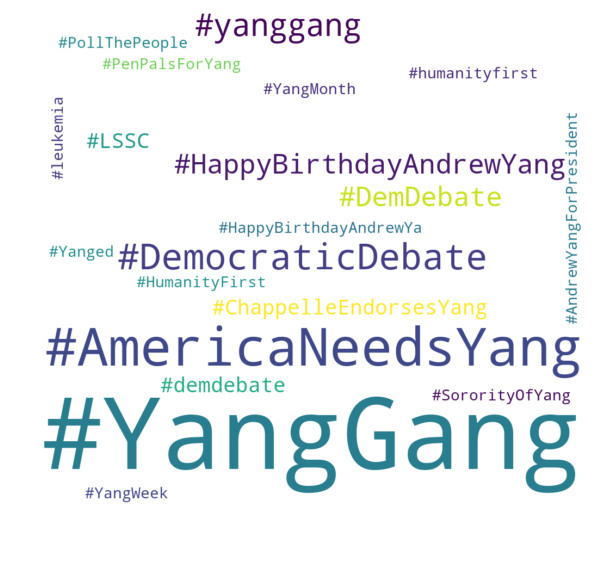

In [99]:
# Make a wordcloud plot of the most used hashtags, for this we need a dictionary 
# where the keys are the words and the values are the number of appearances
hashtag_ordered_dict = {}
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_dict[item[0]] = item[1]
wordcloud = WordCloud(width=1000,height=1000,random_state=21,max_font_size=200,background_color='white').generate_from_frequencies(hashtag_ordered_dict)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

# Most mentioned accounts

In [100]:
# Now we will do the same with the mentions:
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(df['tweet'].apply(mention_pattern.findall))
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1

In [101]:
# Create an ordered list of tuples with the most mentioned users and #the number of times they have been mentioned
mentions_ordered_list =sorted(mentions_dict.items(),key=lambda x:x[1])
mentions_ordered_list = mentions_ordered_list[::-1]
# Pick the 20 top mentioned users to plot and separate the previous #list into two list: 
# one with the users and one with the values
mentions_ordered_values = []
mentions_ordered_keys = []
for item in mentions_ordered_list[0:20]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])

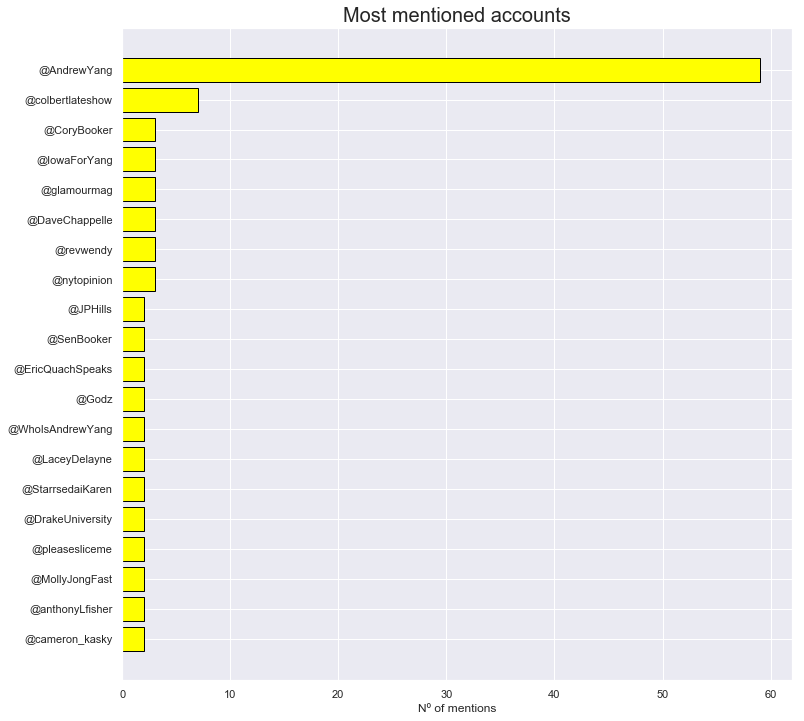

In [102]:
fig, ax = plt.subplots(figsize=(12,12))
y_pos = np.arange(len(mentions_ordered_values))
ax.barh(y_pos,list(mentions_ordered_values)[::-1],align='center',color='yellow',edgecolor='black',linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_xlabel("Nº of mentions")
ax.set_title("Most mentioned accounts",fontsize=20)

plt.show()

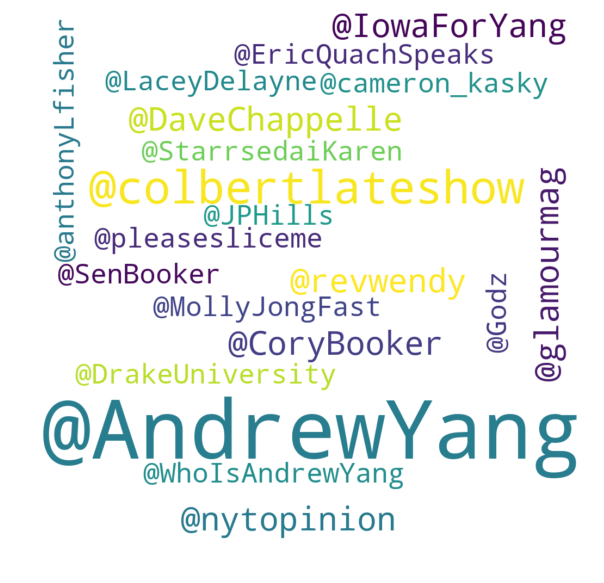

In [103]:
# Make a wordcloud representation for the most mentioned accounts too
mentions_ordered_dict = {}
for item in mentions_ordered_list[0:20]:
    mentions_ordered_dict[item[0]] = item[1]
wordcloud = WordCloud(width=1000,height=1000,random_state=21,max_font_size=200,background_color='white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

In [104]:
# # Lets take a look at the users who are posting these tweets:
# print("There are {} different users".format(df['in_reply_to_screen_name'].nunique()))

In [105]:
# # Going to see who are the users who have tweeted or retweeted the most and see how
# # likely it is that they are bots
# usertweets = tweets.groupby('Username')

# # Taking the top 25 tweeting users
# top_users = usertweets.count()['text'].sort_values(ascending=False)[:25]
# top_users_dict = top_users.to_dict()
# user_ordered_dict =sorted(top_users_dict.items(),key=lambda x:x[1])
# user_ordered_dict = user_ordered_dict[::-1]

# # Now, like in the previous hashtags and mention cases, going to make #two lists, one with the username and one with the value
# dict_values = []
# dict_keys = []
# for item in user_ordered_dict[0:25]:
#     dict_keys.append(item[0])
#     dict_values.append(item[1])
    
# #Plot these results
# fig = plt.figure(figsize=(15,15))
# index = np.arange(25)
# plt.bar(index,dict_values,edgecolor='black',linewidth=1)
# plt.xlabel('Most active Users',fontsize=18)
# plt.ylabel('Nº of Tweets',fontsize=20)
# plt.xticks(index,dict_keys, fontsize=15,rotation=90)
# plt.title('Number of tweets for the most active users',fontsize=20)
# plt.savefig('Tweets_of_active_users.jpg')
# plt.show()

# Which devices are used?

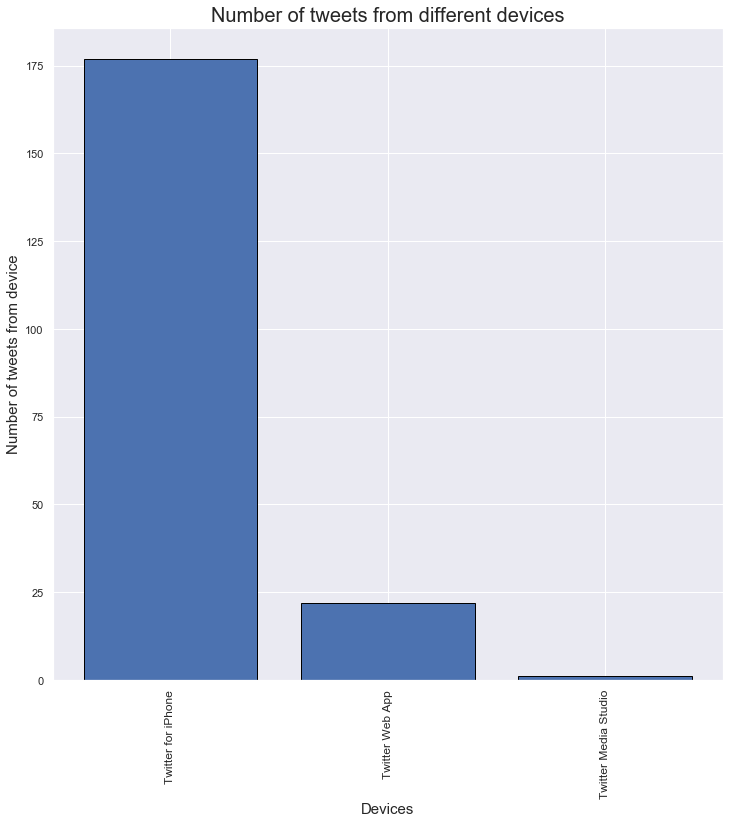

In [106]:
# Now lets explore the different devices where the tweets are #produced from and plot these results
devices = df.groupby("source")
devicecount = devices["tweet"].count()

# Same procedure as the for the mentions, hashtags, etc..
device_dict = devicecount.to_dict()
device_ordered_list =sorted(device_dict.items(),key=lambda x:x[1])
device_ordered_list = device_ordered_list[::-1]
device_dict_values = []
device_dict_keys = []
for item in device_ordered_list:
    device_dict_keys.append(item[0])
    device_dict_values.append(item[1])
    
# Plotting
fig = plt.figure(figsize=(12,12))
index = np.arange(len(device_dict_keys))
plt.bar(index, device_dict_values,edgecolor='black',linewidth=1)
plt.xlabel('Devices',fontsize=15)
plt.ylabel('Number of tweets from device',fontsize=15)
plt.xticks(index,list(device_dict_keys),fontsize=12,rotation=90)
plt.title('Number of tweets from different devices',fontsize=20)

plt.show()

# Portions of different sentiments 

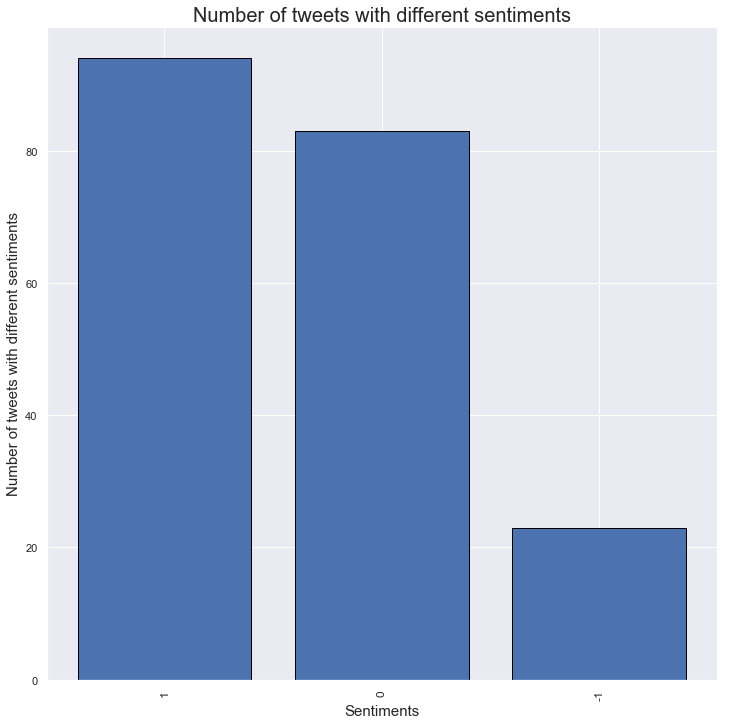

In [107]:
# Now lets explore the number of tweets with different sentiments
sentiments = df.groupby("sentiment")
sentimentcount = sentiments["tweet"].count()

# Same procedure as the for the mentions, hashtags, etc..
sentiment_dict = sentimentcount.to_dict()
sentiment_ordered_list =sorted(sentiment_dict.items(),key=lambda x:x[1])
sentiment_ordered_list = sentiment_ordered_list[::-1]
sentiment_dict_values = []
sentiment_dict_keys = []
for item in sentiment_ordered_list:
    sentiment_dict_keys.append(item[0])
    sentiment_dict_values.append(item[1])
    
# Plotting
fig = plt.figure(figsize=(12,12))
index = np.arange(len(sentiment_dict_keys))
plt.bar(index,sentiment_dict_values,edgecolor='black',linewidth=1)
plt.xlabel('Sentiments',fontsize=15)
plt.ylabel('Number of tweets with different sentiments',fontsize=15)
plt.xticks(index,list(sentiment_dict_keys),fontsize=12,rotation=90)
plt.title('Number of tweets with different sentiments',fontsize=20)

plt.show()

In [52]:
# try:  
#     for tweet in tweepy.Cursor(api.user_timeline,screen_name="theresa_may",exclude_replies=True,count=10).items():  
#                     tweet_text = tweet.text  
#                     time = tweet.created_at  
#                     tweeter = tweet.user.screen_name  
#                     tweet_dict = {"tweet_text":tweet_text.strip(),"timestamp":str(time),"user":tweeter}  
#                     tweet_json = json.dumps(tweet_dict)  
#                     print(tweet_json)  
#     except tweepy.TweepError:  
#         time.sleep(60)

In [53]:
# user_list = ["AaltoUniversity","helsinkiuni","HAAGAHELIAamk","AaltoENG"]
# follower_list = []  
# for user in user_list:  
#     try:   
#         followers = api.followers_ids(screen_name=user)  
#     except tweepy.TweepError:  
#         time.sleep(20)  
#         continue  
#     follower_list.append(followers)

In [54]:
# for index,user in enumerate(user_list):  
#     print("User: "+user+"\t Number of followers: "+str(len(follower_list[index])))

In [55]:
# user_list = ["AaltoUniversity", "helsinkiuni","HAAGAHELIAamk", "AaltoENG"]    
# follower_list = []  
# for user in user_list: 
#     followers = []  
#     try:         
#         for page in tweepy.Cursor(api.followers_ids, screen_name=user).pages():  
#             followers.extend(page)  
#     except tweepy.TweepError:  
#         time.sleep(20)  
#         continue  
#     follower_list.append(followers)

# Average of mentioning of #s per day

In [57]:
# Reading the csv file of json 
ds_tweets = pd.read_csv("data_science_hashtags.csv")
ds_tweets.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,extended_tweet-full_text,favorite_count,favorited,...,retweeted_status,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user,user-screen_name
0,NaN,NaN,Thu Mar 01 07:02:41 +0000 2018,NaN,"{'hashtags': [{'text': 'python', 'indices': [8...",NaN,NaN,NaN,0,False,...,{'created_at': 'Thu Mar 01 06:47:35 +0000 2018...,NaN,Learning Penetration Testing With Python http...,pythonbot_,"<a href=""https://todo.mushfiqweb.com"" rel=""nof...",RT @pythonbot_: Learning Penetration Testing W...,1519887761662,False,"{'id': 67016746, 'id_str': '67016746', 'name':...",mushfiqweb
1,NaN,NaN,Thu Mar 01 07:57:08 +0000 2018,NaN,"{'hashtags': [{'text': 'Software', 'indices': ...",NaN,NaN,NaN,0,False,...,{'created_at': 'Thu Mar 01 07:54:04 +0000 2018...,NaN,Is Language Agnosticism the Future of #Softwar...,I_m_ranjeet,"<a href=""https://www.botlibre.com"" rel=""nofoll...",RT @I_m_ranjeet: Is Language Agnosticism the F...,1519891028660,False,"{'id': 962595301109518336, 'id_str': '96259530...",Dw_Develops
2,NaN,NaN,Thu Mar 01 08:09:02 +0000 2018,NaN,"{'hashtags': [{'text': 'python', 'indices': [0...",NaN,"{'full_text': ""#python goes to #school for #be...",#python goes to #school for #beginner #scienti...,0,False,...,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#python goes to #school for #beginner #scienti...,1519891742657,True,"{'id': 946400503029678080, 'id_str': '94640050...",pinyosminyos
3,NaN,NaN,Thu Mar 01 09:22:21 +0000 2018,"[0, 115]","{'hashtags': [{'text': 'data', 'indices': [66,...","{'media': [{'id': 969140774720847873, 'id_str'...",NaN,NaN,0,False,...,NaN,NaN,NaN,NaN,"<a href=""https://www.nytimes.com/"" rel=""nofoll...",Easy way to set Oracle Active Dataguard\n☞ htt...,1519896141665,False,"{'id': 915436926500462592, 'id_str': '91543692...",datascience_new
4,NaN,NaN,Thu Mar 01 12:04:04 +0000 2018,"[0, 100]","{'hashtags': [{'text': 'python', 'indices': [4...","{'media': [{'id': 969181471796731904, 'id_str'...",NaN,NaN,0,False,...,NaN,NaN,NaN,NaN,"<a href=""https://www.nytimes.com/"" rel=""nofoll...",Python 3 for Beginners\n☞ https://t.co/va5XaJX...,1519905844657,False,"{'id': 912955536823410689, 'id_str': '91295553...",PythonCs


In [58]:
# General information of dc_tweets
# ds_tweets.info()

In [59]:
def check_word_in_tweets(word,df_tweets):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series."""
    
    contains_column = pd.Series()
    contains_column = df_tweets["text"].str.contains(word,case=False)
    contains_column |= contains_column | df_tweets["extended_tweet-full_text"].str.contains(word,case=False)
    contains_column |= df_tweets["quoted_status-text"].str.contains(word,case=False)
    contains_column |= df_tweets["quoted_status-extended_tweet-full_text"].str.contains(word,case=False)
    contains_column |= df_tweets["retweeted_status-text"].str.contains(word,case=False)
    contains_column |= df_tweets["retweeted_status-extended_tweet-full_text"].str.contains(word,case=False)
    
    return contains_column

In [60]:
# Find mentions of keywords in different places
python = check_word_in_tweets("#python",ds_tweets)
rstats = check_word_in_tweets("#rstats",ds_tweets)
machinelearning = check_word_in_tweets("#machinelearning",ds_tweets)
deeplearning = check_word_in_tweets("#deeplearning",ds_tweets)
datascience = check_word_in_tweets("#datascience",ds_tweets)

# Print proportion of tweets mentioning keywords
print("Proportion of #python tweets is:",python.sum()/ds_tweets.shape[0])
print("Proportion of #rstats tweets is:",rstats.sum()/ds_tweets.shape[0])
print("Proportion of #machinelearning tweets is:",machinelearning.sum()/ds_tweets.shape[0])
print("Proportion of #deeplearning tweets is:",deeplearning.sum()/ds_tweets.shape[0])
print("Proportion of #datascience tweets is:",datascience.sum()/ds_tweets.shape[0])

Proportion of #python tweets is: 0.5680068434559452
Proportion of #rstats tweets is: 0.4679213002566296
Proportion of #machinelearning tweets is: 0.0658682634730539
Proportion of #deeplearning tweets is: 0.023952095808383235
Proportion of #datascience tweets is: 0.1377245508982036


In [61]:
# Convert the created_at column to datetime object
ds_tweets["created_at"] = pd.to_datetime(ds_tweets["created_at"])

# Set the index of ds_tweets to created_at
ds_tweets = ds_tweets.set_index("created_at")

ds_tweets.head()

,contributors,coordinates,display_text_range,entities,extended_entities,extended_tweet,extended_tweet-full_text,favorite_count,favorited,filter_level,...,retweeted_status,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user,user-screen_name
created_at,,,,,,,,,,,,,,,,,,,,,
2018-03-01 07:02:41+00:00,NaN,NaN,NaN,"{'hashtags': [{'text': 'python', 'indices': [8...",NaN,NaN,NaN,0,False,low,...,{'created_at': 'Thu Mar 01 06:47:35 +0000 2018...,NaN,Learning Penetration Testing With Python http...,pythonbot_,"<a href=""https://todo.mushfiqweb.com"" rel=""nof...",RT @pythonbot_: Learning Penetration Testing W...,1519887761662,False,"{'id': 67016746, 'id_str': '67016746', 'name':...",mushfiqweb
2018-03-01 07:57:08+00:00,NaN,NaN,NaN,"{'hashtags': [{'text': 'Software', 'indices': ...",NaN,NaN,NaN,0,False,low,...,{'created_at': 'Thu Mar 01 07:54:04 +0000 2018...,NaN,Is Language Agnosticism the Future of #Softwar...,I_m_ranjeet,"<a href=""https://www.botlibre.com"" rel=""nofoll...",RT @I_m_ranjeet: Is Language Agnosticism the F...,1519891028660,False,"{'id': 962595301109518336, 'id_str': '96259530...",Dw_Develops
2018-03-01 08:09:02+00:00,NaN,NaN,NaN,"{'hashtags': [{'text': 'python', 'indices': [0...",NaN,"{'full_text': ""#python goes to #school for #be...",#python goes to #school for #beginner #scienti...,0,False,low,...,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",#python goes to #school for #beginner #scienti...,1519891742657,True,"{'id': 946400503029678080, 'id_str': '94640050...",pinyosminyos
2018-03-01 09:22:21+00:00,NaN,NaN,"[0, 115]","{'hashtags': [{'text': 'data', 'indices': [66,...","{'media': [{'id': 969140774720847873, 'id_str'...",NaN,NaN,0,False,low,...,NaN,NaN,NaN,NaN,"<a href=""https://www.nytimes.com/"" rel=""nofoll...",Easy way to set Oracle Active Dataguard\n☞ htt...,1519896141665,False,"{'id': 915436926500462592, 'id_str': '91543692...",datascience_new
2018-03-01 12:04:04+00:00,NaN,NaN,"[0, 100]","{'hashtags': [{'text': 'python', 'indices': [4...","{'media': [{'id': 969181471796731904, 'id_str'...",NaN,NaN,0,False,low,...,NaN,NaN,NaN,NaN,"<a href=""https://www.nytimes.com/"" rel=""nofoll...",Python 3 for Beginners\n☞ https://t.co/va5XaJX...,1519905844657,False,"{'id': 912955536823410689, 'id_str': '91295553...",PythonCs


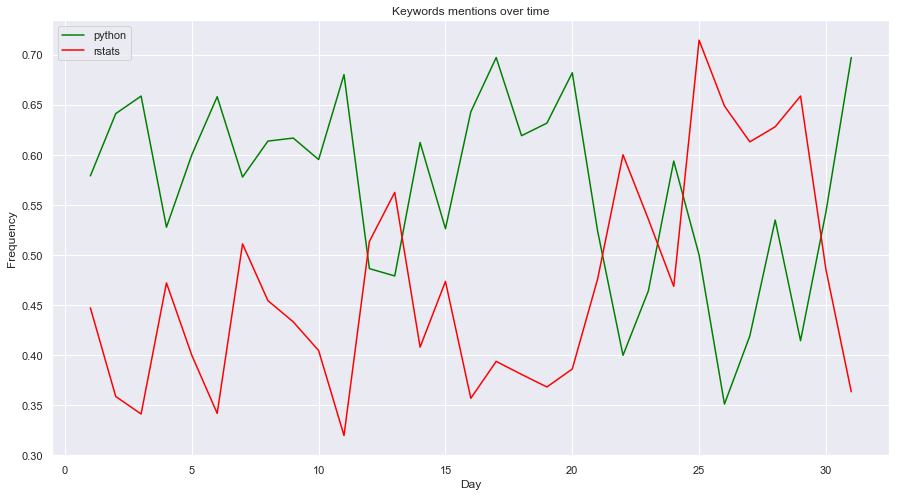

In [110]:
ds_tweets["python"] = check_word_in_tweets("#python",ds_tweets)
ds_tweets["rstats"] = check_word_in_tweets("#rstats",ds_tweets)
ds_tweets["machinelearning"] = check_word_in_tweets("#machinelearning",ds_tweets)
ds_tweets["deeplearning"] = check_word_in_tweets("#deeplearning",ds_tweets)
ds_tweets["datascience"] = check_word_in_tweets("#datascience",ds_tweets)

# Average of keyword columns by day
mean_python = ds_tweets["python"].resample("1 d").mean()
mean_rstats = ds_tweets["rstats"].resample("1 d").mean()
mean_machinelearning = ds_tweets["machinelearning"].resample("1 d").mean()
mean_deeplearning = ds_tweets["deeplearning"].resample("1 d").mean()
mean_datascience = ds_tweets["datascience"].resample("1 d").mean()

# Plotting the keywords
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(mean_python.index.day,mean_python,color="green",label="python")
plt.plot(mean_rstats.index.day,mean_rstats,color="red",label="rstats")
# plt.plot(mean_machinelearning.index.day,mean_machinelearning,color="yellow")
# plt.plot(mean_deeplearning.index.day,mean_deeplearning,color="black")
# plt.plot(mean_datascience.index.day,mean_datascience,color="blue")

plt.xlabel("Day")
plt.ylabel("Frequency")
plt.title("Keywords mentions over time")
plt.legend()
plt.show()

# Average sentiment scores of #s per day

In [63]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alisa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

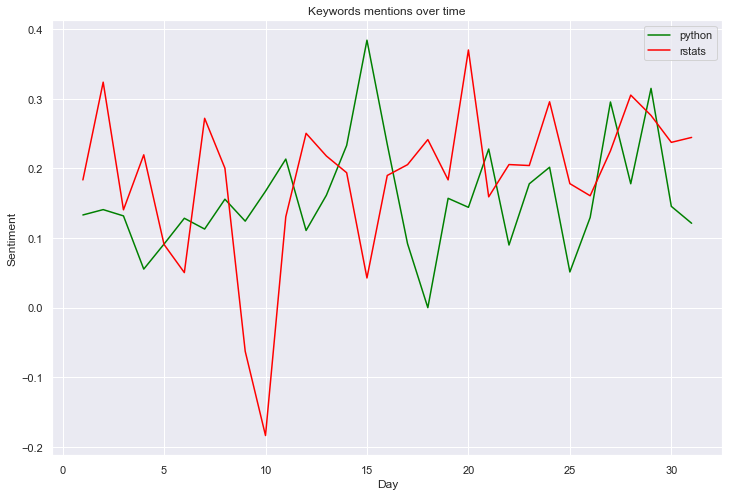

In [109]:
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = ds_tweets["text"].apply(sid.polarity_scores)

# Generating sentiment averages
sentiment = sentiment_scores.apply(lambda x: x["compound"])

# Generate average sentiment scores for differnt keywords
python_sentiment = sentiment[check_word_in_tweets("#python",ds_tweets)].resample("1 d").mean()
rstats_sentiment = sentiment[check_word_in_tweets("#rstats",ds_tweets)].resample("1 d").mean()
machinelearning_sentiment = sentiment[check_word_in_tweets("#machinelearning",ds_tweets)].resample("1 d").mean()
deeplearning_sentiment = sentiment[check_word_in_tweets("#deeplearning",ds_tweets)].resample("1 d").mean()
datascience_sentiment = sentiment[check_word_in_tweets("#datascience",ds_tweets)].resample("1 d").mean()

# Plotting the average sentimint scores
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(python_sentiment.index.day,python_sentiment,color="green",label="python")
plt.plot(rstats_sentiment.index.day,rstats_sentiment,color="red",label="rstats")
# plt.plot(machinelearning_sentiment.index.day,machinelearning_sentiment,color="yellow")
# plt.plot(deeplearning_sentiment.index.day,deeplearning_sentiment,color="black")
# plt.plot(datascience_sentiment.index.day,datascience_sentiment,color="blue")

plt.xlabel("Day")
plt.ylabel("Sentiment")
plt.title("Keywords mentions over time")
plt.legend()
plt.show()

# Network analysis of the retweets of SOTU-2018

[https://networkx.github.io/documentation/stable/](https://networkx.github.io/documentation/stable/)

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

NetworkX provides:

* tools for the study of the structure and dynamics of social, biological, and infrastructure networks;

* a standard programming interface and graph implementation that is suitable for many applications;

* a rapid development environment for collaborative, multidisciplinary projects;

* an interface to existing numerical algorithms and code written in C, C++, and FORTRAN; and

* the ability to painlessly work with large nonstandard data sets.

With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.

In [65]:
# Reading SOTU_2018_rt to a dataframe
sotu_retweets = pd.read_csv("sotu2018_rt.csv")
sotu_retweets.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,...,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,...,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,...,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,...,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN
3,NaN,NaN,Wed Jan 31 02:36:19 +0000 2018,NaN,0,False,low,NaN,958529347828305921,958529347828305921,...,False,NaN,Uh-oh. Our president mentioned the FIRST and S...,TomiLahren,"<a href=""http://twitter.com/download/iphone"" r...",RT @TomiLahren: Uh-oh. Our president mentioned...,1517366179793,False,DAWNSTUTESMAN,NaN
4,NaN,NaN,Wed Jan 31 02:46:24 +0000 2018,NaN,0,False,low,NaN,958531885424173057,958531885424173057,...,False,"Tonight isn't about memos, fake news, free thi...","Tonight isn't about memos, fake news, free thi...",TomiLahren,"<a href=""http://twitter.com/download/android"" ...","RT @TomiLahren: Tonight isn't about memos, fak...",1517366784803,False,SCischk,NaN


In [66]:
# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(sotu_retweets,
                               source="user-screen_name",
                               target="retweeted_status-user-screen_name",
                               create_using=nx.DiGraph())

G_rt

In [67]:
print("Nodes in RT network:",len(G_rt.nodes()))
print("Edges in RT network:",len(G_rt.edges()))

Nodes in RT network: 2287
Edges in RT network: 2340


In [68]:
# Create random layout positions
pos = nx.random_layout(G_rt)

# Create size list
sizes = [x[1] for x in G_rt.degree()]

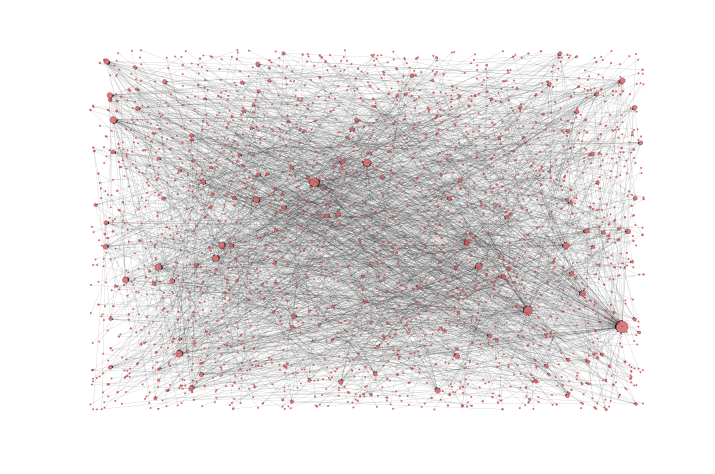

In [69]:
# Drawing the retweet network
plt.rcParams["figure.figsize"] = (12,8)
nx.draw_networkx(G_rt,
                 pos,
                 with_labels=False,
                 node_size=sizes,
                 width=0.1,alpha=0.7,
                 arrowsize=2,linewidth=0)
plt.axis("off")
plt.show()

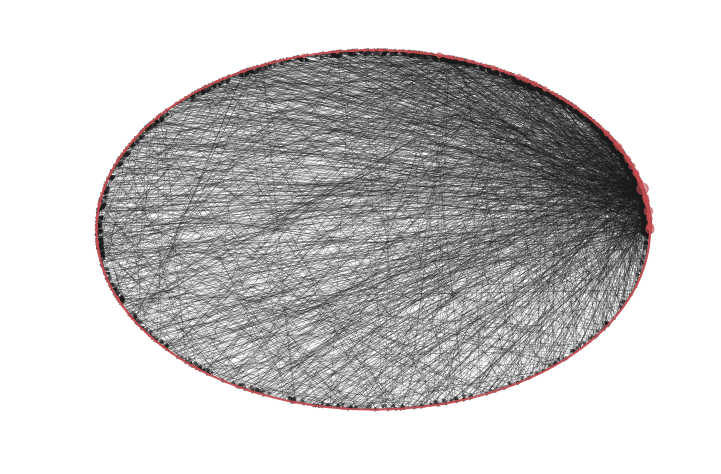

In [70]:
# Circular layout of retweet network
circular_pos = nx.circular_layout(G_rt)

# Drawing of retweet network
nx.draw_networkx(G_rt,
                 pos=circular_pos,
                 node_size=sizes,
                 with_labels=False,
                 width=0.3,alpha=0.6)
plt.axis("off")
plt.show()